In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os

from torchvision.models import ResNet18_Weights, resnet18
from tqdm.notebook import tqdm
from torchvision import datasets, transforms

from src.imagenet_x.evaluate import ImageNetX, get_vanilla_transform
from src.imagenet_x import FACTORS, plots
from src.imagenet_x import get_factor_accuracies, error_ratio

import pickle
from pathlib import Path

In [2]:
imagenet_val_path = '../../data/ImageNetVal'
transforms = get_vanilla_transform()
dataset = ImageNetX(imagenet_val_path, transform=transforms)    

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [93]:
# Load the model
#Default ResNet18.
modelname= 'resnet18'
model = resnet18(weights=ResNet18_Weights.DEFAULT)

#Dino VIT:
#model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')


device = 0
batch_size = 128
num_workers = 4
# Evaluate model on ImageNetX using simple loop
model.eval()
model.to(device)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)
names = loader.dataset.samples

In [4]:
preds = []
probs = []

correct = 0
total = 0
with torch.no_grad():
    for data, target, annotations in loader:
        data, target = data.to(device), target.to(device)
        annotations = annotations.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        prob = output.softmax(dim=1)
        top_p = prob.topk(1, dim=1)[0]
        mask = pred.eq(target.view_as(pred)).to(device)
        correct += annotations[mask,:].to(device).sum(dim=0)
        total += annotations.to(dtype=torch.int).sum(dim=0)
        preds.append(pred.cpu())
        probs.append(top_p.cpu())

In [18]:
preds1 = torch.cat(preds).numpy()
probs1 = torch.cat(probs).numpy()

In [92]:
namesdf = pd.DataFrame(names, columns=['name', 'index'])
namesdf['name'] = namesdf['name'].str.split('/', expand=True)[6].T
namesdf = namesdf.drop(columns=['index'])
df = pd.DataFrame([preds1, probs1], index=['pred', 'probs']).T
df['probs'] = df['probs'].astype(float)
df = pd.concat([namesdf, df], axis=1)

df.to_csv(modelname+'.csv', index=False)

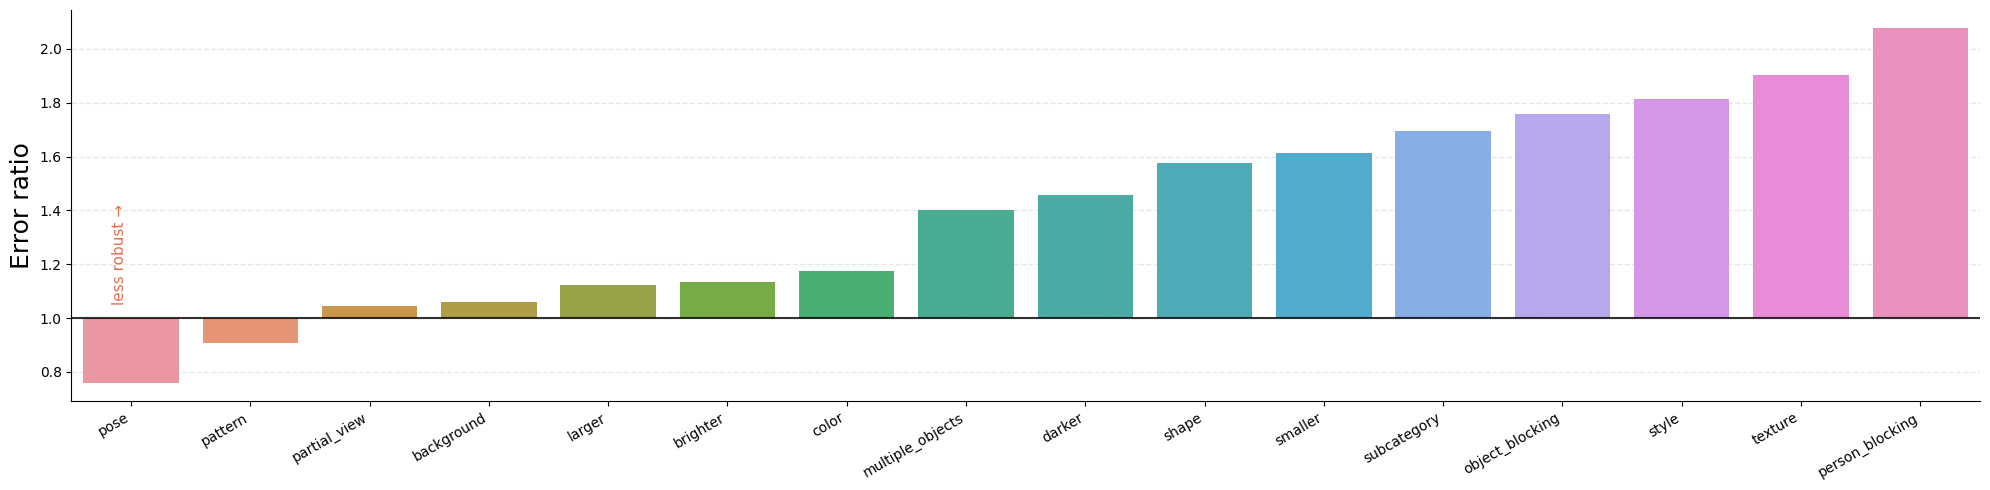

In [46]:
       
# Compute accuracies per factor
factor_accs = (correct/total).cpu().detach().numpy()
results = pd.DataFrame({'Factor': FACTORS, 'acc': factor_accs}).sort_values('acc', ascending=False)

# Compute error ratios per factor
results['Error ratio'] = (1 - results['acc']) / (1-(correct.sum()/total.sum()).item())

# Plot results
plots.plot_bar_plot(results, x='Factor', y='Error ratio')
plt.show()
plt.savefig(modelname+'_error_ratio.png')

In [3]:
factor_accs = get_factor_accuracies("Predictions/")

                          file_name  label
0      ILSVRC2012_val_00000293.JPEG      0
1      ILSVRC2012_val_00002138.JPEG      0
2      ILSVRC2012_val_00003014.JPEG      0
3      ILSVRC2012_val_00006697.JPEG      0
4      ILSVRC2012_val_00007197.JPEG      0
...                             ...    ...
49995  ILSVRC2012_val_00044368.JPEG    999
49996  ILSVRC2012_val_00045266.JPEG    999
49997  ILSVRC2012_val_00046353.JPEG    999
49998  ILSVRC2012_val_00047144.JPEG    999
49999  ILSVRC2012_val_00049174.JPEG    999

[50000 rows x 2 columns]


In [4]:
error_ratio = error_ratio(factor_accs)

In [5]:
from src.imagenet_x import plots

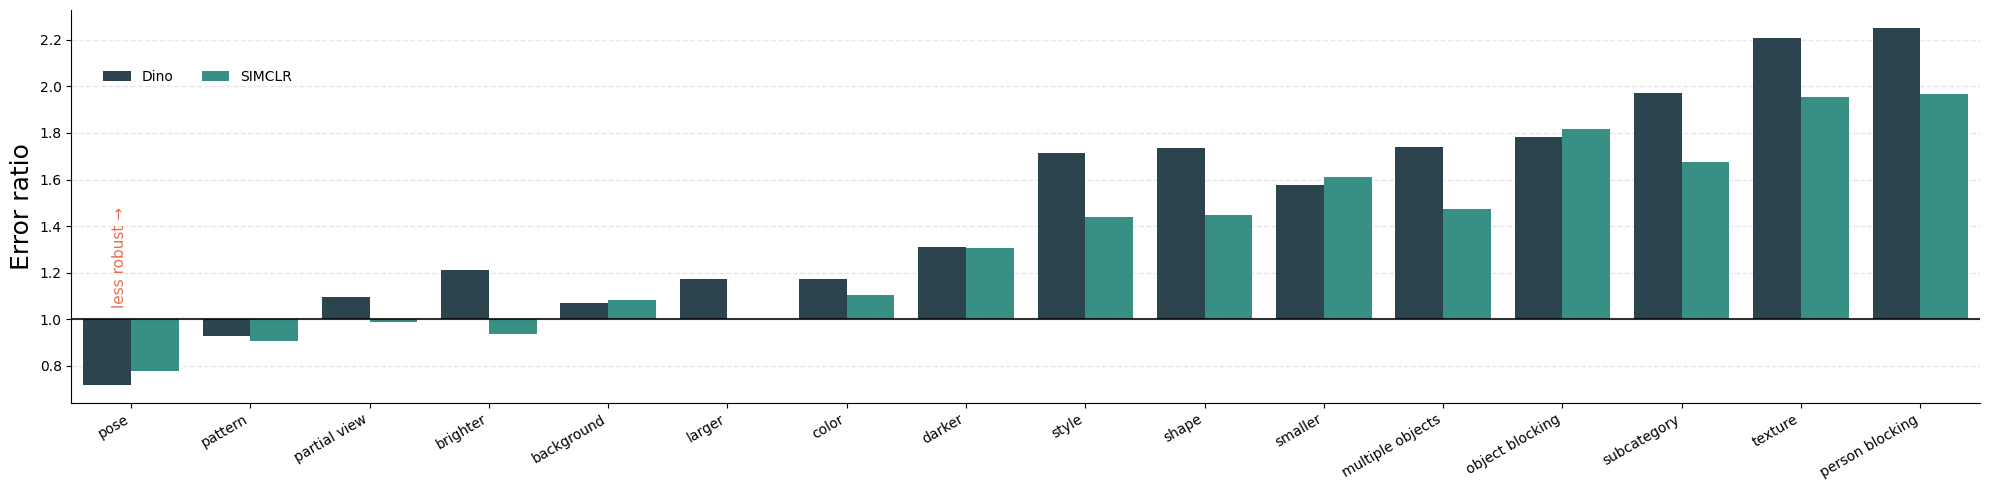

In [6]:
plots.set_color_palette()
plots.model_comparison(factor_accs.reset_index())

In [22]:
files("src.imagenet_x") / "annotations" 

PosixPath('/mnt/c/users/juliu/OneDrive/DTU/bachelor/bachelor_project/src/imagenet_x/annotations')